In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch
import torch.nn as nn
from torchvision import transforms,datasets,models
from torch.nn import Module,Conv2d,MaxPool2d,Linear,Dropout,BatchNorm2d,ReLU,Sequential,Softmax
from torch.utils.data import random_split,DataLoader,Dataset,DataLoader
from torchvision import transforms,datasets,models
from sklearn.model_selection import train_test_split
from torch.optim import Adam
import torch.utils.data as data
from torch.nn import Embedding
import PIL.Image as Image
from warnings import filterwarnings
filterwarnings('ignore')

c:\Users\Dell\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Recurrent Text Generation

### Data preparation

In [56]:
filename = "source.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()
 
# create mapping of unique chars to integers
chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))
 
# summarize the loaded data
n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  561623
Total Vocab:  62


In [57]:

# prepare the dataset of input to output pairs encoded as integers
seq_length = 100
dataX = []
dataY = []
for i in range(0, n_chars - seq_length, 1):
    seq_in = raw_text[i:i + seq_length]
    seq_out = raw_text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns: ", n_patterns)

Total Patterns:  561523


In [58]:
import torch.nn as nn
import torch.optim as optim
 
# reshape X to be [samples, time steps, features]
X = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X = X / float(n_vocab)
y = torch.tensor(dataY)
print(X.shape, y.shape)

torch.Size([561523, 100, 1]) torch.Size([561523])


### Building model

In [59]:
import torch.optim as optim
import torch.utils.data as data
 
class CharModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=256, num_layers=2, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(256, n_vocab)
    def forward(self, x):
        x, _ = self.lstm(x)
        # take only the last output
        x = x[:, -1, :]
        # produce output
        x = self.linear(self.dropout(x))
        return x

In [60]:
n_epochs = 100
batch_size = 128
model = CharModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
 
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction="sum")
loader = data.DataLoader(data.TensorDataset(X, y), shuffle=True, batch_size=batch_size)
 
best_model = None
best_loss = np.inf

for epoch in range(n_epochs):
    model.train()
    running_loss = 0
    for X_batch, y_batch in loader:
        y_pred = model(X_batch.to(device))
        loss = loss_fn(y_pred, y_batch.to(device))
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if(epoch%10==0):
        print("Epoch %d: Train loss: %.4f" % (epoch, running_loss / len(loader)))

    model.eval()
    loss = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            y_pred = model(X_batch.to(device))
            loss += loss_fn(y_pred, y_batch.to(device))
        if loss < best_loss:
            best_loss = loss
            best_model = model.state_dict()
        print("Epoch %d: Cross-entropy: %.4f" % (epoch, loss))
 
torch.save([best_model, char_to_int], "single-char.pth")

Epoch 0: Train loss: 339.8153
Epoch 0: Cross-entropy: 1311734.1250
Epoch 1: Cross-entropy: 1173947.8750
Epoch 2: Cross-entropy: 1098901.8750
Epoch 3: Cross-entropy: 1053770.2500
Epoch 4: Cross-entropy: 1009041.0000
Epoch 5: Cross-entropy: 983157.4375
Epoch 6: Cross-entropy: 955215.8750
Epoch 7: Cross-entropy: 935639.3125
Epoch 8: Cross-entropy: 924778.7500
Epoch 9: Cross-entropy: 902822.0000
Epoch 10: Train loss: 223.4685
Epoch 10: Cross-entropy: 889777.1250
Epoch 11: Cross-entropy: 882066.1250
Epoch 12: Cross-entropy: 868452.8750
Epoch 13: Cross-entropy: 859928.4375
Epoch 14: Cross-entropy: 852948.6875
Epoch 15: Cross-entropy: 837642.4375
Epoch 16: Cross-entropy: 832265.1875
Epoch 17: Cross-entropy: 828881.7500
Epoch 18: Cross-entropy: 816801.2500
Epoch 19: Cross-entropy: 811982.5625
Epoch 20: Train loss: 205.4930
Epoch 20: Cross-entropy: 810383.5625
Epoch 21: Cross-entropy: 801251.3125
Epoch 22: Cross-entropy: 795949.6250
Epoch 23: Cross-entropy: 792651.6875
Epoch 24: Cross-entropy: 

In [83]:
best_model, char_to_int = torch.load("single-char.pth")
n_vocab = len(char_to_int)
int_to_char = dict((i, c) for c, i in char_to_int.items())
model.load_state_dict(best_model)
 
# randomly generate a prompt
filename = "source.txt"
seq_length = 500

prompt = "my eyes tell me that on the inside of your left shoe, just where the firelight strikes it, the leather is scored by six almost parallel cuts. Obviously they have been caused by someone who has very carelessly scraped round the edges of the sole in order to remove crusted mud from it. Hence, you see, my double deduction that you had been out in vile weather, and that you had a particularly malignant boot-slitting specimen of the London slavey. As to your practice, if a gentleman walks into my rooms smelling of iodoform, with black mark of nitrate of silver upon his right forefinger, and a bulge on the right side of his top-hat to show where he has secreted his stethoscope, I must be dull, indeed, if I do not pronounce him to be an active member of the medical profession."
prompt = prompt.lower()
pattern = [char_to_int[c] for c in prompt]
 
model.eval()
print('Prompt:\n "%s"' % prompt)

generated = ""
print("\nGenerated:")

with torch.no_grad():
    for i in range(24):
        # format input array of int into PyTorch tensor
        x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
        x = torch.tensor(x, dtype=torch.float32)
        # generate logits as output from the model
        prediction = model(x.to(device))
        # convert logits into one character
        index = int(prediction.argmax())
        result = int_to_char[index]
        print(result, end="")
        generated += result
        # append the new character into the prompt for the next iteration
        pattern.append(index)
print()
print("Done.")

Prompt:
 "my eyes tell me that on the inside of your left shoe, just where the firelight strikes it, the leather is scored by six almost parallel cuts. obviously they have been caused by someone who has very carelessly scraped round the edges of the sole in order to remove crusted mud from it. hence, you see, my double deduction that you had been out in vile weather, and that you had a particularly malignant boot-slitting specimen of the london slavey. as to your practice, if a gentleman walks into my rooms smelling of iodoform, with black mark of nitrate of silver upon his right forefinger, and a bulge on the right side of his top-hat to show where he has secreted his stethoscope, i must be dull, indeed, if i do not pronounce him to be an active member of the medical profession."

Generated:
 i have no doubt that i 
Done.


## Image generator

In [2]:
# generated = " i have no doubt that i "

In [3]:
def split_string_into_five_words(input_string):
    words = input_string.split()
    result_strings = []

    for i in range(0, len(words), 5):
        five_words = ' '.join(words[i:i+5])
        result_strings.append(five_words)

    return result_strings

text = split_string_into_five_words(generated)
text

['i have no doubt that', 'i']

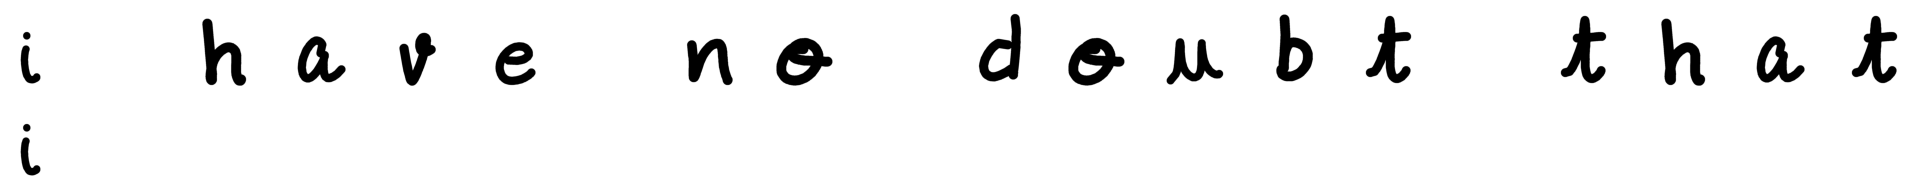

In [5]:
from image_generation import create_image
img = create_image(text)